# 2024 Spoken Wiki attentional word recognition task results

### Analysis is for main diotic experiment
### Models run on all combinations of stimuli
___

In [1]:
import pickle

import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json
import pickle
import importlib 
import IPython.display as ipd
%matplotlib inline 

import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats 
# from matplotlib.ticker import FormatStrFormatter

import src.util_process_prolific as up 
from tqdm import tqdm
importlib.reload(up)

import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)


In [2]:
# outfig_dest = Path('Paper_figs/mono_results/')
# outfig_dest.mkdir(parents=True, exist_ok=True)





### Import human data

In [3]:
path_to_human_data = Path('/mindhive/mcdermott/www/imgriff/msjspsych/')
path_to_expmt_stim = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
# !ls {path_to_human_data}
# full paths to .json files 
human_fnames = list(path_to_human_data.glob("cocktail_party_word_recognition_all_conds/data/*.json"))

len(human_fnames)

428

## Process Human Results

In [4]:
## Get all subject data into one df for analysis

dfs = []
for fname in human_fnames:
    try:
        dfs.append(up.get_part_df_swc(fname))
    except Exception as e:
        print(e)
        print(fname)
    
# results_df = pd.concat([get_part_df(fname) for fname in human_fnames], axis=0, ignore_index=True)
results_df = pd.concat(dfs)

## Filter for those who passed headphone check 
results_df = results_df[results_df.hc_passed == True]
## Filter self reported hearing loss 
results_df = results_df[results_df.hearing_loss == False]
# results_df = results_df[results_df.over_ear_hf == True]

## Add snr and condition names as columns - unpack from file code in file names 

# get cond name map
map_path = path_to_expmt_stim / 'human_attn_expmt_cond_map.pkl' 
with open(map_path, 'rb') as handle:
    stim_cond_map = pickle.load(handle)
stim_cond_map = {f"condition_{k:02}": v for k,v in stim_cond_map.items()}

# add as columns 
results_df['snr'], results_df['condition'] = zip(*results_df['stimulus'].apply(lambda x: up.get_stim_snr_and_cond(x, stim_cond_map=stim_cond_map)))

# cut down df to only have trial answers (remove other meta data)
expmnt_trial_str = "dictionary-text"
trial_results = results_df[results_df.trial_type == expmnt_trial_str].copy()
trial_results.rename(columns={"condition":"raw_condition"}, inplace=True)

# Convert condition names to  readable format 
test_condition_dict = {'music':"background_musdb18hq",
                       "babble":"background_cv08talkerbabble",
                       "stationary": "background_issnstationary",
                       "natural scene": "background_ieeeaaspcasa",
                       "clean": "SILENCE"}
# 1-talker conds preserved in replace below

condition_map = {v:k for k,v in test_condition_dict.items()}
trial_results['condition'] = trial_results['raw_condition'].replace(condition_map)

# screen based on completion 
total_trials = 196
full_run_subjects = [subj_id for subj_id, did_all_trials in (trial_results.groupby('id_subject').condition.count() == total_trials).items() if did_all_trials == True]
trial_results = trial_results[trial_results.id_subject.isin(full_run_subjects)]
# Add accuracy 
trial_results['accuracy'] = (trial_results['response'] == trial_results['correct_response']).astype('int')

# add shortened stim name field 
trial_results['stim_name'] = trial_results['stimulus'].str.split('/').str[-1].str.split('.').str[0]

# drop coluns in trial_results that are all nans 
trial_results = trial_results.dropna(axis=1, how='all')

Unterminated string starting at: line 1 column 84194 (char 84193)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_6658b1491e88ec15902d5301.json
Unterminated string starting at: line 1 column 192613 (char 192612)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_6174b049932ee98236563b51.json
Unterminated string starting at: line 1 column 72207 (char 72206)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_65dc99d0191a135ab835bf69.json
Unterminated string starting at: line 1 column 324626 (char 324625)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_5c0430c71a20110001e9b05a.json
Expecting ',' delimiter: line 1 column 204794 (char 204793)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_666883e7cd549b6798159085.json
Unterminated string starting at: line 1 column 60213

In [5]:
# catch_trial_particiapnt_performance
catch_trial_particiapnt_performance = trial_results[trial_results.condition == 'catch_trial'].groupby('id_subject').accuracy.mean()

print("N total participants ", len(catch_trial_particiapnt_performance))
good_participants = catch_trial_particiapnt_performance[catch_trial_particiapnt_performance >= 11/12].index
print("N good participants ", len(good_participants))

good_results = trial_results[trial_results.id_subject.isin(good_participants)]
analysis_df = good_results[(~good_results.condition.isnull()) & (~good_results.response.isna())]
analysis_df = analysis_df.dropna(axis=1, how='all').dropna(axis=0, how='all')
# analysis_df.groupby('id_subject').condition.count()

N total participants  208
N good participants  195


In [6]:
### Get quick demographics 
demog_fields = results_df[results_df.id_subject.isin(good_participants)]
demogs = demog_fields.groupby('id_subject').first()
print("Gender data")
print(demogs.gender.value_counts())
print("Age data")
demogs['age'] = [int(age) if age != '' else np.nan for age in demogs.age ]
print(f"Min: {demogs.age.min()} Max: {demogs.age.max()} Median: {demogs.age.median()}")

Gender data
gender
Female                  98
Male                    92
Other                    4
Prefer not to answer     1
Name: count, dtype: int64
Age data
Min: 18.0 Max: 71.0 Median: 33.0



#### Add re-scored performance based on entries included in excerpt transcripts  

In [ ]:
### Make map from cv dictionary ixs to experiment word ixs 

## import cv maps
import pickle
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}


## import experiment word map
human_exp_word_key = pickle.load( open(path_to_expmt_stim / "human_attn_expmt_word_key.pkl", "rb" )) 
exp_word_2_class = {v:k for k,v in human_exp_word_key.items()}



In [8]:
## Will add columns 'base_str', 'target_gender', 'target_f0', 'distractor_f0', 'distractor_gender' from manifests to trial_results where trial_results.stimulus == manifests.base_str

manifests = pd.read_pickle(path_to_expmt_stim / "human_cue_target_distractor_df_w_meta_transcripts_w_f0.pdpkl")
# add columns for word int and stim name to map back to participant data 
manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)
manifests['stim_name'] = manifests[['gender', 'word_fname_int']].apply(lambda row: f"{row.gender[0]}_{row.word_fname_int:03d}", axis=1)

cols_to_merge = ['stim_name',
                 'gender',
                 'word',
                 'target_f0',
                 'english_distractor_f0',
                 'mandarin_distractor_f0',
                 'dutch_distractor_f0',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word"
]

analysis_df = pd.merge(analysis_df,
                        manifests[cols_to_merge],
                                    left_on='stim_name', right_on='stim_name', how='left')
analysis_df['confusions'] = (analysis_df.response == analysis_df.same_sex_dist_1_word).astype('int')
analysis_df['accuracy'] = (analysis_df.response == analysis_df.word).astype('int')


# add adjusted accuracy and confusions 
pred_words = analysis_df.response.values
target_words = analysis_df.word.values
target_transcripts = analysis_df.target_transcripts.values
same_sex_distractor_words = analysis_df.same_sex_dist_1_word.values
diff_sex_distractor_words = analysis_df.diff_sex_dist_1_word.values
same_sex_distractor_transcripts = analysis_df.same_sex_distractor_1_transcripts.values
diff_sex_distractor_transcripts = analysis_df.diff_sex_distractor_1_transcripts.values


adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                            if not isinstance(target_transcript, float) else np.nan
                            for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                            ])

adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                            if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                            for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                            ])

analysis_df['adjusted_accuracy'] = adjusted_acc
analysis_df['adjusted_confusions'] = adjusted_confs

## Remap 1-talker distractor names accordingly 

analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'sex_cond'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].str.split('-').str[-1].str.title()
analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'dist_lang'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].str.split('-').str[-2].str.title()

def remap_1_distractor_str(cond_str):
    if 'english' in cond_str:
        return '1-talker'
    if 'mandarin' in cond_str:
        return "Mandarin distractor"
    if 'dutch' in cond_str:
        return "Dutch distractor"

analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].apply(remap_1_distractor_str)
analysis_df = analysis_df[~analysis_df.condition.isin(['catch_trial', "Dutch distractor"])]



/tmp/ipykernel_2651762/3084302696.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)


In [9]:
to_check = analysis_df[analysis_df.condition!="catch_trial"]
(to_check.adjusted_accuracy >= to_check.accuracy).all()

True

In [ ]:
analysis_df.condition.unique()

array(['stationary', 'Mandarin distractor', 'natural scene', 'clean',
       '1-talker', 'babble', '2-talker', '4-talker', 'music'],
      dtype=object)

In [11]:
##########################
# Make df for f0 analysis 
##########################

# drop unwanted conditions
f0_analysis_df = analysis_df[analysis_df.condition.isin([ "1-talker", 'Mandarin distractor', 'clean'])].copy()

# cut and remove language-specific f0 columns - just make distractor f0 
f0_analysis_df.loc[f0_analysis_df.dist_lang == 'English', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'English', 'english_distractor_f0'].values
f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Mandarin', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Mandarin', 'mandarin_distractor_f0'].values
# f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Dutch', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Dutch', 'dutch_distractor_f0'].values

f0_analysis_df["abs_f0_diff"] = np.abs(f0_analysis_df.target_f0 - f0_analysis_df.distractor_f0)
f0_analysis_df["percent_f0_diff"] = f0_analysis_df.distractor_f0 / f0_analysis_df.target_f0 
def get_f0_ratio(row):
    return max(row.target_f0, row.distractor_f0) / min(row.target_f0, row.distractor_f0)
f0_analysis_df["f0_ratio"] = f0_analysis_df.apply(get_f0_ratio, axis=1)

# # rename condition to background condition
f0_analysis_df = f0_analysis_df.rename(columns={"condition": "background_condition"})
f0_analysis_df = f0_analysis_df.dropna(axis=1,  how = 'all')
# get columns with trial in their name
cols_to_drop = [col for col in f0_analysis_df.columns if 'trial' in col ]
# drop prolific meta columns
f0_analysis_df = f0_analysis_df.drop(columns=cols_to_drop).reset_index(drop=True)


In [12]:
# get trial data excluding catch trials 

part_summary_df = (analysis_df.groupby(["snr", 'id_subject', "condition"])
                     .agg({'correct':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

part_summary_df['snr'] = part_summary_df['snr'].replace(np.inf, 6)
part_summary_df['snr'] =  part_summary_df['snr'].replace("inf", 6)
part_summary_df['snr'] = part_summary_df['snr'].astype('int')
# flatten multiindex 
part_summary_df.columns = ['_'.join(col).strip() for col in part_summary_df.columns.values]
# remove trailing underscore
part_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in part_summary_df.columns.values]


/tmp/ipykernel_2651762/1597215865.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  part_summary_df['snr'] =  part_summary_df['snr'].replace("inf", 6)


In [ ]:
## Summarize participant data for aggregate plotting


summary_df = part_summary_df.groupby(['snr', 'condition']).agg({'correct_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']


## Load Model Results 

In [14]:
## import class maps
import pickle
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}

### Get conditions 
cond_map = pickle.load( open(path_to_expmt_stim / "human_attn_expmt_cond_map.pkl", "rb" )) 
conds = set([cond for cond,snr in cond_map.values()])

test_cond_to_human = {v:k for k,v in test_condition_dict.items()}
cond_remap = {}
for cond in conds:
    if cond in test_cond_to_human:
        cond_remap[cond] = test_cond_to_human[cond]
    else:
        cond_remap[cond] = cond 
cond_remap['natural scene'] = 'natural scene'


In [15]:

model_names = [
    # "word_task_half_co_loc_v10_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout",
                # "word_task_v08_control_no_attn",
                # "word_task_v10_control_no_attn",
                # "word_task_early_only_v10",
                # "word_task_late_only_v10",
                # "word_task_half_co_loc_v10_50Hz_cutoff",
                # "word_task_conventional_layer_order"
                ]# "word_task_half_co_loc_v08_gender_bal_4M_w_no_cue_learned"]

# get names for arch_search models 
arch_search_models = [path.stem for path in Path('swc_2024_eval_full_stim/').glob('*v10*')]
model_names.extend(arch_search_models)

model_name_dict = {
                   'word_task_v10_control_no_attn': 'Baseline CNN',
                   'word_task_early_only_v10': 'Early-only',
                   'word_task_late_only_v10': 'Late-only',
                   "word_task_v10_main_feature_gain_config": 'Feature-gain Model',

                  }




all_model_results = []
all_model_f0_results = []

background_conditions = summary_df.background_condition.unique() 
str_to_cond = {v:k for k,v in test_condition_dict.items()}

## preselect manifest columns 
cols_to_merge = [
                #  'stim_name',
                 'gender',
                 'word',
                 'word_int',
                 'target_f0',
                 'english_distractor_f0',
                 'mandarin_distractor_f0',
                 'dutch_distractor_f0',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word"

]

manifests['word_int'] = manifests.word.replace(cv_word_2_class)
model_manifest = manifests[cols_to_merge].sort_values(['gender', 'word']).copy()
model_manifest['df_index'] = model_manifest.index

# update gt manifests to match readable format 
for model_name in model_names:
    print(model_name)
    output_paths = list(Path(f'swc_2024_eval_full_stim/{model_name}').glob('*.csv'))
    print(len(output_paths))
    results_dfs = []

    for path in output_paths:
        # print(path)
        try:
            df = pd.read_csv(path)
            # reformat dict
            df['model'] = path.parent.name
            #parts of name 
            parts = path.stem.split(path.parent.name)[-1].split('_')   
            # if 'stim_tag' in df.columns:
            #     # rename 
            #     df.rename(columns={'stim_tag':'stim_name'}, inplace=True)
            # use re to split path.stem after model name and before <int>dB 
            df['background_condition'] = [v for v in cond_remap.values() if "_".join(v.split(' ')) in path.stem][0]
            if 'clean' in path.stem:
                df['background_condition'] = 'clean'
                df['snr'] =  'inf' # really np.inf, 6 for plotting 
            else:
                df['snr'] = int(re.search('(-?\d+)dB', path.stem).group(0).strip('dB'))

            df['test_index'] = df.index
            df = pd.merge(df,
                model_manifest,
                            left_on=["test_index", "true_word_int"], right_on=["df_index", "word_int"])
            if 'dutch' in df['background_condition'].unique()[0]:
                continue
            results_dfs.append(df)
        except Exception as e:
            # print(e)
            continue

    model_results = pd.concat(results_dfs, axis=0, ignore_index=True)
    if model_name in model_name_dict:
        model_str = model_name_dict[model_name]
    elif "arch_" in model_name:
        model_str = "Feature-gain Model"
    else:
        model_str = model_name

    model_results['group'] = model_str
    ## Load in model vocab 
    model_results['pred_word'] = model_results['pred_word_int'].replace(cv_class_2_word)
    model_results['true_word'] = model_results['true_word_int'].replace(cv_class_2_word)


    # Add 1-talker condition metadata to model results

    # add confusions 
    model_results['confusions'] = (model_results.pred_word == model_results.same_sex_dist_1_word).astype('int')

    # add adjusted accuracy and confusions 
    pred_words = model_results.pred_word.values
    target_words = model_results.word.values
    target_transcripts = model_results.target_transcripts.values
    same_sex_distractor_words = model_results.same_sex_dist_1_word.values
    diff_sex_distractor_words = model_results.same_sex_dist_1_word.values
    same_sex_distractor_transcripts = model_results.same_sex_distractor_1_transcripts.values
    diff_sex_distractor_transcripts = model_results.diff_sex_distractor_1_transcripts.values


    adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                                if not isinstance(target_transcript, float) else np.nan
                                for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                                ])

    adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                                if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                                for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                                ])
    
    model_results['adjusted_accuracy'] = adjusted_acc
    model_results['adjusted_confusions'] = adjusted_confs
    model_results.loc[model_results.background_condition.str.contains('1-talker'), 'sex_cond'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].str.split('-').str[-1].str.title()
    model_results.loc[model_results.background_condition.str.contains('1-talker'), 'dist_lang'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].str.split('-').str[-2].str.title()
    model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].apply(remap_1_distractor_str)

    
    all_model_results.append(model_results)


    model_f0_df = model_results[model_results.background_condition.isin([ "1-talker", 'Mandarin distractor', 'Dutch distractor', 'clean'])].copy()
    model_f0_df.loc[model_f0_df.dist_lang == 'English', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'English', 'english_distractor_f0'].values
    model_f0_df.loc[model_f0_df.dist_lang == 'Mandarin', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'Mandarin', 'mandarin_distractor_f0'].values
    model_f0_df.loc[model_f0_df.dist_lang == 'Dutch', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'Dutch', 'dutch_distractor_f0'].values
    model_f0_df["abs_f0_diff"] = np.abs(model_f0_df.target_f0 - model_f0_df.distractor_f0)
    model_f0_df["percent_f0_diff"] = model_f0_df.distractor_f0 / model_f0_df.target_f0 
    model_f0_df["f0_ratio"] = model_f0_df.apply(get_f0_ratio, axis=1)
    model_f0_df.loc[:, "abs_f0_diff"] = np.abs(model_f0_df.target_f0 - model_f0_df.distractor_f0)
    model_f0_df.loc[:, "percent_f0_diff"] = model_f0_df.distractor_f0 / model_f0_df.target_f0 
    all_model_f0_results.append(model_f0_df)

all_model_results = pd.concat(all_model_results, axis=0, ignore_index=True)
all_model_f0_results = pd.concat(all_model_f0_results, axis=0, ignore_index=True)

/tmp/ipykernel_2651762/2861186813.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_int'] = manifests.word.replace(cv_word_2_class)


word_task_early_only_v10
61
word_task_late_only_v10
61
word_task_v10_4MGB_ln_first_arch_1
61
word_task_v10_4MGB_ln_first_arch_10
61
word_task_v10_4MGB_ln_first_arch_12
61
word_task_v10_4MGB_ln_first_arch_2
61
word_task_v10_4MGB_ln_first_arch_4
61
word_task_v10_4MGB_ln_first_arch_6
61
word_task_v10_4MGB_ln_first_arch_7
61
word_task_v10_4MGB_ln_first_arch_8
61
word_task_v10_4MGB_ln_first_arch_9
61
word_task_v10_backbone_learned_gains
61
word_task_v10_backbone_word_babble_and_noise_no_gains
61
word_task_v10_backbone_word_config_ecdf_gains
61
word_task_v10_backbone_word_config_no_gains
61
word_task_v10_backbone_word_config_no_gains_old_ckpt
61
word_task_v10_backbone_word_config_old_ckpt
61
word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_feature_gains
61
word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_gains
61
word_task_v10_backbone_word_config_w_babble_all_coloc_no_gains
61
word_task_v10_backbone_word_config_w_babble_ecdf_feature_gains
61
word_task_v10_backbone_word_c

In [ ]:
# Adjusted accuracy should always greater than or equal to accuracy
(all_model_results['adjusted_accuracy'] >= all_model_results['accuracy']).all() 

True

In [17]:
all_model_results.group.unique()

array(['Early-only', 'Late-only', 'Feature-gain Model',
       'word_task_v10_backbone_learned_gains',
       'word_task_v10_backbone_word_babble_and_noise_no_gains',
       'word_task_v10_backbone_word_config_ecdf_gains',
       'word_task_v10_backbone_word_config_no_gains',
       'word_task_v10_backbone_word_config_no_gains_old_ckpt',
       'word_task_v10_backbone_word_config_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_feature_gains',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_gains',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_no_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_feature_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_feature_gains_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_ecdf_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_gains_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_no_gains',
       'word_task_

In [18]:
N = int(summary_df.N.unique().item())

summary_df['group'] = f'Humans (N={N})'
# model_results['group'] = model_results['group']
# all_model_results = all_model_results[all_model_results.snr > -12]
# combine model and participant results ignore missing columns
combined_results = pd.concat([summary_df, all_model_results], axis=0, ignore_index=True)

In [19]:
combined_results.loc[combined_results.snr == np.inf, 'snr'] = 6
combined_results.loc[combined_results.snr == 'inf', 'snr'] = 6
combined_results.snr = combined_results.snr.astype('int')

combined_results['background_condition'].rename({"stationary":"noise"}, inplace=True)
# combined_results = combined_results[combined_results.snr > -12]
combined_results.loc[combined_results.background_condition == "stationary", 'background_condition'] = "noise"


In [20]:
model_list = combined_results.group.unique()

In [21]:
model_list

array(['Humans (N=195)', 'Early-only', 'Late-only', 'Feature-gain Model',
       'word_task_v10_backbone_learned_gains',
       'word_task_v10_backbone_word_babble_and_noise_no_gains',
       'word_task_v10_backbone_word_config_ecdf_gains',
       'word_task_v10_backbone_word_config_no_gains',
       'word_task_v10_backbone_word_config_no_gains_old_ckpt',
       'word_task_v10_backbone_word_config_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_feature_gains',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_gains',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_no_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_feature_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_feature_gains_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_ecdf_gains',
       'word_task_v10_backbone_word_config_w_babble_ecdf_gains_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_no_gains',


# Main analysis of Model averages vs Humans 

In [22]:
model_results.columns

Index(['pred_word_int', 'true_word_int', 'accuracy', 'model',
       'background_condition', 'snr', 'test_index', 'gender', 'word',
       'word_int', 'target_f0', 'english_distractor_f0',
       'mandarin_distractor_f0', 'dutch_distractor_f0', 'target_transcripts',
       'same_sex_distractor_1_transcripts',
       'diff_sex_distractor_1_transcripts', 'same_sex_dist_1_word',
       'diff_sex_dist_1_word', 'df_index', 'group', 'pred_word', 'true_word',
       'confusions', 'adjusted_accuracy', 'adjusted_confusions', 'sex_cond',
       'dist_lang'],
      dtype='object')

In [23]:
all_model_results.model.unique()

array(['word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_learned_gains',
       'word_task_v10_backbone_word_babble_and_noise_no_gains',
       'word_task_v10_backbone_word_config_ecdf_gains',
       'word_task_v10_backbone_word_config_no_gains',
       'word_task_v10_backbone_word_config_no_gains_old_ckpt',
       'word_task_v10_backbone_word_config_old_ckpt',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_feature_gains',
       'word_task_v10_backbone_word_config_w_babble_all_coloc_ecdf_gains',
       'word_task_v10_backbone_word

In [24]:
### Merge all feature based models into one group

models_to_summary = all_model_results[all_model_results.group == "Feature-gain Model"].copy()

## Summarize participant data for aggregate plotting
# get trial data excluding catch trials 


models_summary_df = (models_to_summary.groupby(['model', "snr", "background_condition"])
                     .agg({'accuracy':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

models_summary_df['snr'] = models_summary_df['snr'].replace(np.inf, 6)
models_summary_df['snr'] =  models_summary_df['snr'].replace("inf", 6)
models_summary_df['snr'] = models_summary_df['snr'].astype('int')
# flatten multiindex 
models_summary_df.columns = ['_'.join(col).strip() for col in models_summary_df.columns.values]
# remove trailing underscore
models_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in models_summary_df.columns.values]


fba_summary_df = models_summary_df.groupby(['snr', 'background_condition']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_summary_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']
fba_summary_df['group'] = 'Feature-gain Model'

/tmp/ipykernel_2651762/1062600483.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  models_summary_df['snr'] =  models_summary_df['snr'].replace("inf", 6)


## Save Human and model results for offline use 

In [ ]:
# ## Save pre-combined model results - will be used for bootstrap
# out_dir = Path("final_results_dir")
# out_dir.mkdir(parents=True, exist_ok=True)

# # summary_df.to_pickle(out_dir / "summary_2024_SWC_diotic_participant_results.pdpkl")
# # models_summary_df.to_pickle(out_dir / "summary_2024_SWC_diotic_model_results.pdpkl")

## Summarize models and plot w participants

In [ ]:
## merge with human data 
N = int(summary_df.N.unique().item())

summary_df['group'] = f'Humans (N={N})'
# model_results['group'] = model_results['group']
# all_model_results = all_model_results[all_model_results.snr > -12]
# combine model and participant results ignore missing columns
human_fba_results = pd.concat([summary_df, fba_summary_df], axis=0, ignore_index=True)

human_fba_results.loc[human_fba_results.snr == np.inf, 'snr'] = 6
human_fba_results.loc[human_fba_results.snr == 'inf', 'snr'] = 6
human_fba_results.snr = human_fba_results.snr.astype('int')

human_fba_results['background_condition'].rename({"stationary":"noise"}, inplace=True)
# human_fba_results = human_fba_results[human_fba_results.snr > -12]
human_fba_results.loc[human_fba_results.background_condition == "stationary", 'background_condition'] = "noise"


In [27]:
human_fba_results[(human_fba_results.group.str.contains('Humans')) & (human_fba_results.snr == 0) & (human_fba_results.background_condition == '2-talker')]

,snr,background_condition,accuracy,acc_std_error,confusions,conf_std_error,N,adjusted_accuracy,adj_acc_std_error,adjusted_confusions,adj_conf_std_error,group
25,0,2-talker,0.389744,0.020887,0.032051,0.006001,195,0.500427,0.021332,0.094872,0.011051,Humans (N=195)


In [28]:
human_fba_results[human_fba_results.background_condition == 'clean']

,snr,background_condition,accuracy,acc_std_error,confusions,conf_std_error,N,adjusted_accuracy,adj_acc_std_error,adjusted_confusions,adj_conf_std_error,group
40,6,clean,0.682479,0.01779,0.001282,0.001282,195,0.880769,0.013149,0.002564,0.001808,Humans (N=195)
81,6,clean,0.819775,0.00394,0.000307,0.000157,10,0.839959,0.004551,0.001844,0.000256,Feature-gain Model


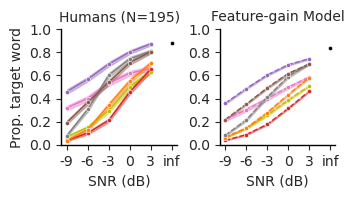

In [29]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = human_fba_results[(~human_fba_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(human_fba_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'noise',  'music', 'natural scene']
palette={}
palette['clean'] = 'k'
palette['1-talker'] = 'tab:pink'
palette['2-talker'] = 'y'
palette['babble'] = 'tab:orange'
palette['4-talker'] = 'tab:red'
palette['noise'] = 'grey'
palette['music'] = 'tab:purple'
palette['natural scene'] = 'tab:brown'
# palette['Mandarin distractor'] = 'teal'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = human_fba_results.group.unique()

n_models = len(models)

aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', ]
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1


for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)


# set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# 
# plt.tight_layout()
plt.savefig(fig_out_dir/'human_v_model_acc_.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

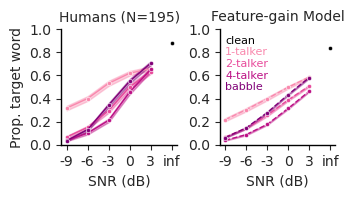

In [30]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = human_fba_results[(~human_fba_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(human_fba_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble'] # 'noise',  'music', 'natural scene']
palette={}
palette['clean'] = 'k'

# set speech color gradient 
speech_palette = sns.color_palette("RdPu_r")
speech_order = hue_order[1:][::-1]

for ix, group in enumerate(speech_order):
    palette[group] = speech_palette[ix]

# palette['Mandarin distractor'] = 'teal'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = human_fba_results.group.unique()

n_models = len(models)

aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', ]
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1


for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[0].legend(loc='upper left', fontsize=6, frameon=False, handlelength=0, handletextpad=0.5, labelspacing=0.2)

# add text as legend to panel 1

for ix, group in enumerate(hue_order):
    axs[1].text(-9, 0.9 - ix * 0.1, group, color=palette[group], fontsize=8, ha='left', va='center')

# set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# 
# plt.tight_layout()
# plt.savefig(fig_out_dir/'human_v_model_acc_speech_only.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

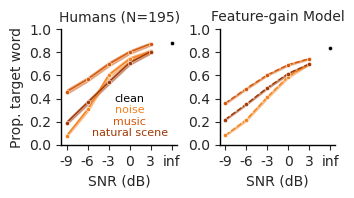

In [31]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = human_fba_results[(~human_fba_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(human_fba_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['clean', 'noise',  'music', 'natural scene']
# palette={}
# palette['clean'] = 'k'

# set noise color gradient 
noise_palette = sns.color_palette("YlOrBr_r", n_colors=6)
noise_order = hue_order[1:][::-1]

for ix, group in enumerate(noise_order):
    palette[group] = noise_palette[ix]

# palette['Mandarin distractor'] = 'teal'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = human_fba_results.group.unique()

n_models = len(models)

aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', ]
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1


for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[0].legend(loc='upper left', fontsize=6, frameon=False, handlelength=0, handletextpad=0.5, labelspacing=0.2)

# add text as legend to panel 1

for ix, group in enumerate(hue_order):
    axs[0].text(0, 0.4 - ix * 0.1, group, color=palette[group], fontsize=8, ha='center', va='center')

# set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# 
# plt.tight_layout()
# plt.savefig(fig_out_dir/'human_v_model_acc_noise_only.pdf', transparent=True, bbox_inches='tight')
# 
# adjust w space 

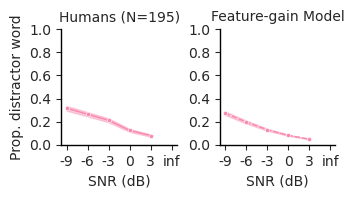

In [32]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = human_fba_results[(~human_fba_results.background_condition.isin(["catch_trial", 'audioset'])) ]
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['1-talker']
# palette={}
# palette['clean'] = 'k'
# palette['1-talker'] = 'tab:pink'
# palette['2-talker'] = 'y'
# palette['babble'] = 'tab:orange'
# palette['4-talker'] = 'tab:red'
# palette['noise'] = 'grey'
# palette['music'] = 'tab:purple'
# palette['natural scene'] = 'tab:brown'
# palette['Mandarin distractor'] = 'teal'

fontsize=10
tick_fontsize = 10
# fontsize = 10

aspect = 1.5
n_models = len(models)
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))

err_band_alpha = 0.4
# add markers to relplot
models = human_fba_results.group.unique()

x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1

for ax, model in zip(axs, models):
    ax.plot(x_tick_locs, np.ones(len(x_tick_locs)) * 0.5, 'w', alpha=0.5, label=None)

    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_confusions', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_conf_std_error'] = selected['adj_conf_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_confusions", yerr="adj_conf_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_confusions'] - selected['adj_conf_std_error'],
                         selected['adjusted_confusions'] + selected['adj_conf_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
# axs[0].legend().remove()
# axs[1].legend().remove()
# axs[0].set_ylabel("Prop. distractor word", fontsize=fontsize)
# axs[1].set_ylabel("", fontsize=fontsize)
# axs[2].set_ylabel("", fontsize=fontsize)

# # move axs[1] legend 
# axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. distractor word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# set space between pannels 
# plt.subplots_adjust(wspace=0.5)

# plt.tight_layout()
# plt.savefig(fig_out_dir/'human_v_model_conf_english.pdf', transparent=True, bbox_inches='tight')
# 
# adjust w space 

In [41]:
all_model_f0_results.background_condition.unique()

array(['1-talker', 'Mandarin distractor', 'clean'], dtype=object)

In [46]:
all_model_f0_results_to_analyze = all_model_f0_results[all_model_f0_results.background_condition != "Dutch distractor"].copy()
all_model_f0_results_to_analyze['id_subject'] = all_model_f0_results_to_analyze['group']
all_model_f0_results_to_analyze.loc[all_model_f0_results_to_analyze.snr == 'inf', 'sex_cond'] = 'Clean'
all_model_f0_results_to_analyze.loc[all_model_f0_results_to_analyze.snr == 'inf', 'dist_lang'] = 'None'


# don't include Baseline CNN in model results
# wanted_model_f0_results = all_model_f0_results_to_analyze # [all_model_f0_results_to_analyze.group.isin(wanted_models)]
wanted_model_f0_results = all_model_f0_results_to_analyze[all_model_f0_results_to_analyze.group == "Feature-gain Model"].copy()


model_dist_df = (wanted_model_f0_results.groupby(["snr", "model", "sex_cond", "dist_lang"])
                     .agg({'accuracy':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

model_dist_df['snr'] = model_dist_df['snr'].replace(np.inf, 6)
model_dist_df['snr'] =  model_dist_df['snr'].replace("inf", 6)
model_dist_df['snr'] = model_dist_df['snr'].astype('int')
# flatten multiindex 
model_dist_df.columns = ['_'.join(col).strip() for col in model_dist_df.columns.values]
# remove trailing underscore
model_dist_df.columns = [col[:-1] if col.endswith('_') else col for col in model_dist_df.columns.values]

# human summary

### Human distractor sex summary 
model_summary_sex_cond_df = model_dist_df.groupby(['snr', 'sex_cond']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
model_summary_sex_cond_df.columns = ['snr', 'sex_cond', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

### Human distractor language summary 
model_summary_dist_lang_df = model_dist_df.groupby(['snr', 'dist_lang']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
model_summary_dist_lang_df.columns = ['snr', 'dist_lang', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

# add group tag back 
model_summary_sex_cond_df['group'] = 'Feature-gain Model'
model_summary_dist_lang_df['group'] = 'Feature-gain Model'


/tmp/ipykernel_2651762/3799946332.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_dist_df['snr'] =  model_dist_df['snr'].replace("inf", 6)


In [47]:
model_summary_sex_cond_df

,snr,sex_cond,accuracy,acc_std_error,confusions,conf_std_error,N,adjusted_accuracy,adj_acc_std_error,adjusted_confusions,adj_conf_std_error,group
0,-9,Different,0.357428,0.017439,0.000871,0.000309,20,0.365471,0.017879,0.068238,0.016195,Feature-gain Model
1,-9,Same,0.188217,0.017091,0.201178,0.046687,20,0.193186,0.017263,0.209221,0.047412,Feature-gain Model
2,-6,Different,0.450359,0.017183,0.000973,0.000241,20,0.461424,0.017523,0.048002,0.011103,Feature-gain Model
3,-6,Same,0.270799,0.019657,0.147592,0.034444,20,0.277715,0.019982,0.153484,0.034909,Feature-gain Model
4,-3,Different,0.535246,0.014873,0.000410,0.000137,20,0.548002,0.015164,0.030020,0.006701,Feature-gain Model
5,-3,Same,0.369314,0.019784,0.099949,0.023517,20,0.377920,0.020303,0.104098,0.023833,Feature-gain Model
6,0,Different,0.609836,0.012663,0.000564,0.000174,20,0.625051,0.012788,0.019826,0.004078,Feature-gain Model
7,0,Same,0.468596,0.016382,0.062090,0.014407,20,0.479098,0.016859,0.065625,0.014564,Feature-gain Model
8,3,Different,0.668391,0.009626,0.000154,0.000084,20,0.684939,0.009785,0.011014,0.002148,Feature-gain Model
9,3,Same,0.564395,0.013090,0.037346,0.008577,20,0.577305,0.013766,0.040625,0.008699,Feature-gain Model


In [48]:
# # combine f0_to_analyze and model_f0_df keeping only columns in both
# model_f0_df['id_subject'] = 'model'
# model_f0_df['group'] = 'model'
f0_to_analyze = f0_analysis_df[f0_analysis_df.dist_lang != 'Dutch'].copy()
f0_to_analyze['group'] =  f'Humans (N={N})'
f0_to_analyze.loc[f0_to_analyze.snr == 'inf', 'sex_cond'] = 'Clean'
f0_to_analyze.loc[f0_to_analyze.snr == 'inf', 'dist_lang'] = 'None'


f0_to_analyze.reset_index(inplace=True, drop=True)


human_dist_df = (f0_to_analyze.groupby(["snr", "id_subject", "sex_cond", "dist_lang"])
                     .agg({'correct':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

human_dist_df['snr'] = human_dist_df['snr'].replace(np.inf, 6)
human_dist_df['snr'] =  human_dist_df['snr'].replace("inf", 6)
human_dist_df['snr'] = human_dist_df['snr'].astype('int')
# flatten multiindex 
human_dist_df.columns = ['_'.join(col).strip() for col in human_dist_df.columns.values]
# remove trailing underscore
human_dist_df.columns = [col[:-1] if col.endswith('_') else col for col in human_dist_df.columns.values]

# human summary

### Human distractor sex summary 
summary_sex_cond_df = human_dist_df.groupby(['snr', 'sex_cond']).agg({'correct_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_sex_cond_df.columns = ['snr', 'sex_cond', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

### Human distractor language summary 
summary_dist_lang_df = human_dist_df.groupby(['snr', 'dist_lang']).agg({'correct_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_dist_lang_df.columns = ['snr', 'dist_lang', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

### combine with model 
## distractor sex 
N = int(f0_to_analyze.id_subject.nunique())
summary_sex_cond_df['group'] = f'Humans (N={N})'
combined_dist_sex_results = pd.concat([summary_sex_cond_df, model_summary_sex_cond_df], axis=0, ignore_index=True)
combined_dist_sex_results.loc[combined_dist_sex_results.snr == np.inf, 'snr'] = 6
combined_dist_sex_results.loc[combined_dist_sex_results.snr == 'inf', 'snr'] = 6
combined_dist_sex_results.snr = combined_dist_sex_results.snr.astype('int')

## distractor language 
summary_dist_lang_df['group'] = f'Humans (N={N})'
combined_dist_lang_results = pd.concat([summary_dist_lang_df, model_summary_dist_lang_df], axis=0, ignore_index=True)
combined_dist_lang_results.loc[combined_dist_lang_results.snr == np.inf, 'snr'] = 6
combined_dist_lang_results.loc[combined_dist_lang_results.snr == 'inf', 'snr'] = 6
combined_dist_lang_results.snr = combined_dist_lang_results.snr.astype('int')


/tmp/ipykernel_2651762/1383330469.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  human_dist_df['snr'] =  human_dist_df['snr'].replace("inf", 6)


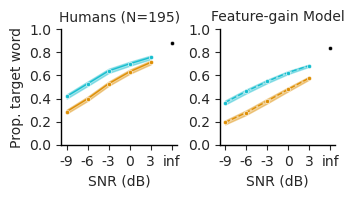

In [49]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = combined_dist_sex_results.copy()
# don't plot baseline 
# to_plot = to_plot[to_plot.group != 'Baseline CNN']
# hue_order = summary_df.sex_cond.unique()
hue_order = ['Different', 'Same', 'Clean']

palette = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Clean'] = 'k'
palette['Different'] = 'tab:cyan'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
sem_order = 1

err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', "Baseline CNN"]
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='sex_cond', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('sex_cond'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != f'Humans (N={N})':
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# # set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# /
# plt.savefig(fig_out_dir/'human_model_save_diff_sex_acc.pdf', transparent=True, bbox_inches='tight')



In [37]:
### get model conf results 
# # combine f0_analysis_df and model_f0_df keeping only columns in both
# model_f0_df['id_subject'] = 'model'
# model_f0_df['group'] = 'model'
all_model_f0_results['id_subject'] = all_model_f0_results['group']
all_model_f0_results.loc[all_model_f0_results.snr == 'inf', 'sex_cond'] = 'Clean'
all_model_f0_results.loc[all_model_f0_results.snr == 'inf', 'dist_lang'] = 'None'


# don't include Baseline CNN in model results
wanted_model_f0_results = all_model_f0_results[(all_model_f0_results.group == "Feature-gain Model") &  (all_model_f0_results.dist_lang == 'English')].copy()

model_dist_df = (wanted_model_f0_results.groupby(["snr", "model", "sex_cond"])
                     .agg({'accuracy':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

model_dist_df['snr'] = model_dist_df['snr'].replace(np.inf, 6)
model_dist_df['snr'] =  model_dist_df['snr'].replace("inf", 6)
model_dist_df['snr'] = model_dist_df['snr'].astype('int')
# flatten multiindex 
model_dist_df.columns = ['_'.join(col).strip() for col in model_dist_df.columns.values]
# remove trailing underscore
model_dist_df.columns = [col[:-1] if col.endswith('_') else col for col in model_dist_df.columns.values]

# human summary

### Human distractor sex summary 
model_summary_sex_cond_df = model_dist_df.groupby(['snr', 'sex_cond']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
model_summary_sex_cond_df.columns = ['snr', 'sex_cond', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

# add group tag back 
model_summary_sex_cond_df['group'] = 'Feature-gain Model'
model_summary_sex_cond_df

,snr,sex_cond,accuracy,acc_std_error,confusions,conf_std_error,N,adjusted_accuracy,adj_acc_std_error,adjusted_confusions,adj_conf_std_error,group
0,-9,Different,0.298258,0.016560,0.001434,0.000533,10,0.305020,0.017033,0.132889,0.013350,Feature-gain Model
1,-9,Same,0.123053,0.009911,0.401127,0.017855,10,0.127561,0.010269,0.412193,0.018316,Feature-gain Model
2,-6,Different,0.394057,0.017141,0.001537,0.000382,10,0.404816,0.017724,0.091803,0.009684,Feature-gain Model
3,-6,Same,0.195902,0.011559,0.294262,0.015124,10,0.201434,0.011879,0.302049,0.015478,Feature-gain Model
4,-3,Different,0.483607,0.014308,0.000512,0.000229,10,0.496311,0.014933,0.056250,0.006043,Feature-gain Model
5,-3,Same,0.293340,0.012906,0.199283,0.011933,10,0.299795,0.013258,0.204816,0.011998,Feature-gain Model
6,0,Different,0.564959,0.011741,0.000615,0.000273,10,0.580533,0.011889,0.035963,0.003437,Feature-gain Model
7,0,Same,0.405738,0.011389,0.123463,0.006266,10,0.414344,0.011571,0.127664,0.006318,Feature-gain Model
8,3,Different,0.633504,0.008690,0.000102,0.000102,10,0.650102,0.009215,0.019365,0.001959,Feature-gain Model
9,3,Same,0.512193,0.007798,0.074078,0.003276,10,0.522336,0.008158,0.077869,0.003336,Feature-gain Model


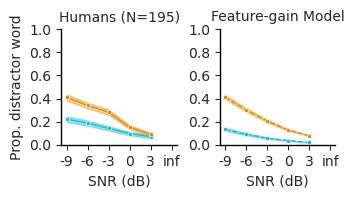

In [38]:
# to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
to_plot = human_dist_df[human_dist_df.dist_lang == 'English']
# to_plot = to_plot[to_plot.group != 'Baseline CNN']

N = int(to_plot.id_subject.nunique())
to_plot = to_plot.groupby(['snr', 'sex_cond']).agg({'correct_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
to_plot.columns = ['snr', 'sex_cond', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']


## distractor sex 
to_plot['group'] = f'Humans (N={N})'
combined_dist_sex_results_confs = pd.concat([to_plot, model_summary_sex_cond_df], axis=0, ignore_index=True)
combined_dist_sex_results_confs.loc[combined_dist_sex_results_confs.snr == np.inf, 'snr'] = 6
combined_dist_sex_results_confs.loc[combined_dist_sex_results_confs.snr == 'inf', 'snr'] = 6
combined_dist_sex_results_confs.snr = combined_dist_sex_results_confs.snr.astype('int')

# don't plot baseline 
# to_plot = combined_dist_sex_results_confs[combined_dist_sex_results_confs.group != 'Baseline CNN']
to_plot = combined_dist_sex_results_confs.copy()

# hue_order = summary_df.sex_cond.unique()
hue_order = ['Different', 'Same', 'Clean']

palette = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Clean'] = 'k'
palette['Different'] = 'tab:cyan'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))

err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', "Baseline CNN"]
# x_tick_locs = to_plot.snr.unique()
# x_tick_locs = np.append(x_tick_locs, [6])
# x_tick_labels = [str(x) for x in x_tick_locs]
# x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order =1 
for ax, model in zip(axs, models):
    ax.plot(x_tick_locs, np.ones(len(x_tick_locs)) * 0.5, 'w', alpha=0.5, label=None)
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_confusions', hue='sex_cond', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('sex_cond'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group
        selected['adj_conf_std_error'] = selected['adj_conf_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_confusions", yerr="adj_conf_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_confusions'] - selected['adj_conf_std_error'],
                         selected['adjusted_confusions'] + selected['adj_conf_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model !=  f'Humans (N={N})':
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend


sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. distractor word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)


# # set space between pannels 
# plt.subplots_adjust(wspace=0.01)


# plt.savefig(fig_out_dir/'human_model_same_diff_sex_confs.pdf', transparent=True, bbox_inches='tight')



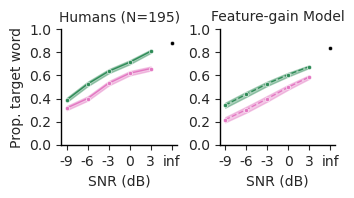

In [39]:
to_plot = combined_dist_lang_results.copy()
# to_plot = to_plot[to_plot.group != 'Baseline CNN']

to_plot.loc[to_plot.dist_lang == 'None', "dist_lang"] = 'No distractor'
to_plot.loc[to_plot.dist_lang.isna(), "dist_lang"] = 'No distractor'

# hue_order = summary_df.dist_lang.unique()
cmap = sns.color_palette("gnuplot2", n_colors=3)

hue_order = ['No distractor','Mandarin' , 'English', 'Dutch',]
hue_plot_order = ['No distractor', 'English', 'Mandarin']
# palette = dict(zip(hue_order, sns.color_palette(n_colors= len(hue_order), as_cmap=True)))

palette = {lang:cmap[ix] for ix, lang in enumerate(hue_order[1:])}
palette['No distractor'] = 'k'
palette['English'] = 'tab:pink'
palette['Mandarin'] = 'seagreen'
palette['Dutch'] = 'orange'


fontsize=10
tick_fontsize = 10
# fontsize = 10

models = to_plot.group.unique()

# aspect = 3
n_models = len(models)
# fig, axs = plt.subplots(1, n_models, figsize=((n_models) * aspect , aspect ))
# aspect = 2
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))

# aspect = 2
# fig, axs = plt.subplots(1, 3, figsize=((aspect) * 3.5 , aspect ))

err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', 'Baseline CNN']
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order
for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='dist_lang', hue_order=hue_plot_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('dist_lang'):
        if not group in hue_plot_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)
# set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# plt.savefig(fig_out_dir/'human_model_unfamiliar_language.pdf', transparent=True, bbox_inches='tight')



## Combine same/diff sex for scatter plot

In [46]:
combined_dist_sex_results.sex_cond = combined_dist_sex_results.sex_cond.replace({'Different': "Different sex", 'Same': "Same sex"})
combined_dist_sex_results['background_condition'] = combined_dist_sex_results.sex_cond.values 
### Add to combined results 
sex_results_to_merge =  combined_dist_sex_results[['snr', 'background_condition',  'adjusted_accuracy', 'adj_acc_std_error',
       'adjusted_confusions', 'adj_conf_std_error', 'group']].copy().reset_index()
res_for_scatter = pd.concat([human_fba_results, sex_results_to_merge], ignore_index=True)


### Need to adjust same vs different sex confusions to only reflect english talkers 
# get data for confusions 
human_conf_df = human_dist_df[human_dist_df.dist_lang == 'English']
# to_plot = to_plot[to_plot.group != 'Baseline CNN']

N = int(human_conf_df.id_subject.nunique())
human_conf_df = human_conf_df.groupby(['snr', 'sex_cond']).agg({'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
human_conf_df.columns = ['snr', 'sex_cond', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']

## distractor sex 
human_conf_df['group'] = f'Humans (N={N})'
model_conf_to_merge = all_model_f0_results[ (all_model_f0_results.dist_lang == 'English')].copy()

conf_results_df = pd.concat([human_conf_df, model_conf_to_merge], axis=0, ignore_index=True)
conf_results_df.loc[conf_results_df.snr == np.inf, 'snr'] = 6
conf_results_df.loc[conf_results_df.snr == 'inf', 'snr'] = 6
conf_results_df.snr = conf_results_df.snr.astype('int')
conf_results_df.sex_cond = conf_results_df.sex_cond.replace({'Different': "Different sex", 'Same': "Same sex"})
conf_results_df.background_condition = conf_results_df.sex_cond.values 

## update confusions by snr and sex condition 
conf_results =  conf_results_df[['snr', 'background_condition',
       'adjusted_confusions', 'adj_conf_std_error', 'group']].copy().reset_index(drop=True)
# add one talker results to combined conf results 
conf_results = pd.concat([conf_results, human_fba_results.loc[human_fba_results.background_condition == '1-talker', ['group', 'snr', 'background_condition', 'adjusted_confusions', 'adj_conf_std_error']].reset_index(drop=True)
                     ], ignore_index=True)

## Combine and save for sharing 

In [ ]:
res_for_scatter

In [53]:
res_for_scatter.background_condition.unique()

array(['1-talker', '2-talker', '4-talker', 'Mandarin distractor',
       'babble', 'music', 'natural scene', 'noise', 'clean',
       'Different sex', 'Same sex', 'Clean'], dtype=object)

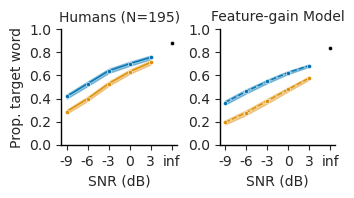

In [55]:
sex_conds = ['Clean', 'Different sex', 'Same sex']
to_plot = res_for_scatter[res_for_scatter.background_condition.isin(sex_conds)].copy()
to_plot


# don't plot baseline 
# to_plot = to_plot[to_plot.group != 'Baseline CNN']
# hue_order = summary_df.sex_cond.unique()
hue_order = ['Mandarin distractor', 'Same sex', 'Clean']

palette = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Clean'] = 'k'
palette['Different'] = 'tab:cyan'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
sem_order = 1

err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', "Baseline CNN"]
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='adjusted_accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['adj_acc_std_error'] = selected['adj_acc_std_error'] * sem_order
        # ax.errorbar(data=selected, x="snr", y="adjusted_accuracy", yerr="adj_acc_std_error", color=palette[group], marker=None, ls='none' )
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['adjusted_accuracy'] - selected['adj_acc_std_error'],
                         selected['adjusted_accuracy'] + selected['adj_acc_std_error'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != f'Humans (N={N})':
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
# axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# # set space between pannels 
# plt.subplots_adjust(wspace=0.01)
# /
# plt.savefig(fig_out_dir/'human_model_save_diff_sex_acc.pdf', transparent=True, bbox_inches='tight')

